# LDA applications
After you learned the principle behind the LDA, let’s go through some application cases to have a more vivid experience of its magic power. The applications of LDA mainly includes four parts: data visualization, classification, feature extraction, and data compression. 

In [1]:
import matplotlib.pyplot as plt
import pandas as pd

from mpl_toolkits.mplot3d import Axes3D
from sklearn import datasets
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

## LDA for data visualization

### Dataset
The dataset here we used is UCI Iris Data Set. The data set contains 3 classes of 50 instances each, where each class refers to a type of iris plant. One class is linearly separable from the other 2; the latter are NOT linearly separable from each other. Four features were measured from each sample: the length and the width of the sepals and petals, in centimeters.

<img src="https://sebastianraschka.com/images/blog/2014/linear-discriminant-analysis/iris_petal_sepal.png">

Let's take a glance at the dataset.

In [2]:
iris = datasets.load_iris()

X = iris.data
y = iris.target
target_names = iris.target_names

df = pd.DataFrame(X, columns=["sepal length", "sepal width", "petal length", "petal width"])
df.head()

,sepal length,sepal width,petal length,petal width
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2


When a dataset has more than three features, since normally, we can only plot 2D or 3D points, we need to draw multiple plots to illustrate all the features, which is very unintuitive. As we showed below, in the case of Iris Data Set, we need six 2D plots and four 3D plots to include all the features.

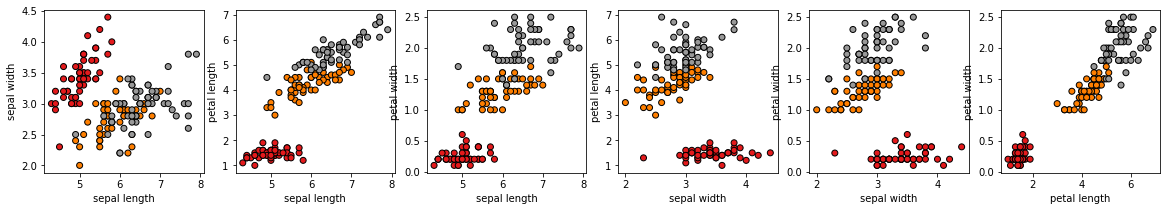

In [3]:
fig = plt.figure(1, figsize=(20, 3))
k = 0

for i in range(4):
    for j in range(4):
        if i < j:
            k += 1
            ax = fig.add_subplot(160 + k)

            ax.scatter(X[:, i], X[:, j], c=y, cmap=plt.cm.Set1, edgecolor='k')

            ax.set_xlabel(df.columns[i])
            ax.set_ylabel(df.columns[j])

plt.show()

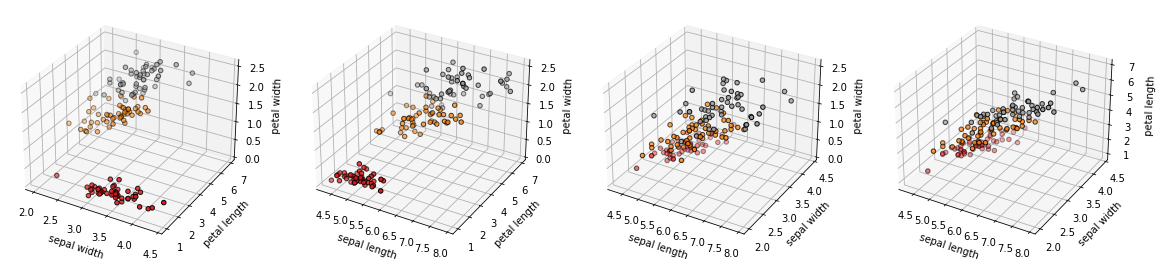

In [4]:
fig = plt.figure(1, figsize=(20, 6))

for i in range(4):
    ax = fig.add_subplot(140 + (i + 1), projection='3d')
    
    feature_index = list(range(4))
    feature_index.remove(i)
    ax.scatter(X[:, feature_index[0]], X[:, feature_index[1]], X[:, feature_index[2]], c=y, cmap=plt.cm.Set1, edgecolor='k')

    ax.set_xlabel(df.columns[feature_index[0]])
    ax.set_ylabel(df.columns[feature_index[1]])
    ax.set_zlabel(df.columns[feature_index[2]])

plt.show()

### Experiments
Here, we applied LDA to reduce the dimentionalities of the Iris Data Set from four to two. In this way, we can display the data with a 2D plot. As we can see from the plot, the result of LDA is fairly good that data points from different classes are separated.

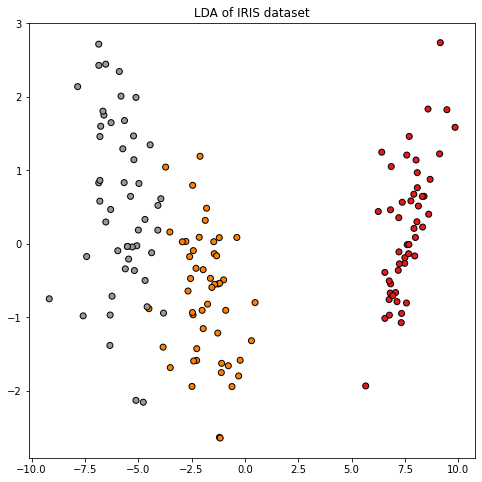

In [5]:
lda = LDA(n_components=2)
X_r2 = lda.fit(X, y).transform(X)

plt.figure(figsize=(8, 8))
plt.scatter(X_r2[:, 0], X_r2[:, 1], c=y, cmap=plt.cm.Set1,  edgecolor='k')
plt.title('LDA of IRIS dataset')

plt.show()

## LDA for classification
### Dataset
The dataset here we used is a part of MNIST database, which is a large database of handwritten digits that is commonly used for training various image processing systems and training/testing in the field of machine learning. Here we scaled the images into 8 * 8, and only used the first 6 classes (digits from 0 to 5).

In [6]:
from time import time
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import offsetbox
from sklearn import (manifold, datasets, decomposition, ensemble,
                     discriminant_analysis, random_projection, neighbors)

digits = datasets.load_digits(n_class=6)
X = digits.data
y = digits.target
n_samples, n_features = X.shape
n_neighbors = 30

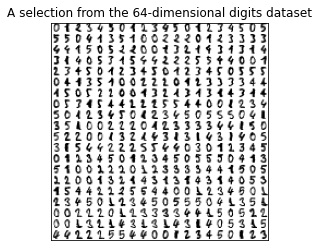

In [7]:
# Scale and visualize the embedding vectors
def plot_embedding(X, title=None, figsize=(10, 10)):
    x_min, x_max = np.min(X, 0), np.max(X, 0)
    X = (X - x_min) / (x_max - x_min)

    plt.figure(figsize=figsize)
    ax = plt.subplot(111)
    for i in range(X.shape[0]):
        plt.text(X[i, 0], X[i, 1], str(y[i]),
                 color=plt.cm.Set1(y[i] / 10.),
                 fontdict={'weight': 'bold', 'size': 9})

    if hasattr(offsetbox, 'AnnotationBbox'):
        # only print thumbnails with matplotlib > 1.0
        shown_images = np.array([[1., 1.]])  # just something big
        for i in range(X.shape[0]):
            dist = np.sum((X[i] - shown_images) ** 2, 1)
            if np.min(dist) < 4e-3:
                # don't show points that are too close
                continue
            shown_images = np.r_[shown_images, [X[i]]]
            imagebox = offsetbox.AnnotationBbox(
                offsetbox.OffsetImage(digits.images[i], cmap=plt.cm.gray_r),
                X[i])
            ax.add_artist(imagebox)
    plt.xticks([]), plt.yticks([])
    if title is not None:
        plt.title(title)

# Plot images of the digits
n_img_per_row = 20
img = np.zeros((10 * n_img_per_row, 10 * n_img_per_row))
for i in range(n_img_per_row):
    ix = 10 * i + 1
    for j in range(n_img_per_row):
        iy = 10 * j + 1
        img[ix:ix + 8, iy:iy + 8] = X[i * n_img_per_row + j].reshape((8, 8))

plt.imshow(img, cmap=plt.cm.binary)
plt.xticks([])
plt.yticks([])
plt.title('A selection from the 64-dimensional digits dataset')
plt.show()

### Experiments
As we mentioned in the data visualization parts, unlike random projection, the result of LDA enjoyed a strength that data points from different classes are separated. Taking advantage of this strength, we can use LDA on the classification tasks such as the handwritten digit recognition problem, with the help of some simple approaches like K-NearestNeighbor(KNN).

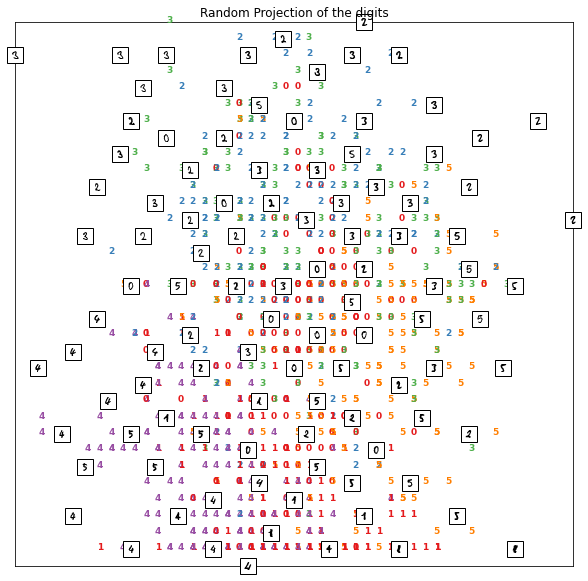

In [8]:
# Random 2D projection using a random unitary matrix
rp = random_projection.SparseRandomProjection(n_components=2, random_state=42)
X_projected = rp.fit_transform(X)
plot_embedding(X_projected, "Random Projection of the digits")

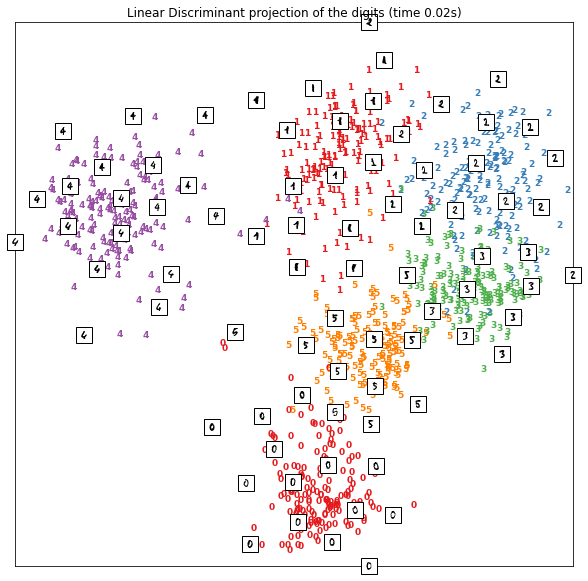

In [9]:
X2 = X.copy()
X2.flat[::X.shape[1] + 1] += 0.01  # Make X invertible
t0 = time()
X_lda = discriminant_analysis.LinearDiscriminantAnalysis(n_components=2).fit_transform(X2, y)
plot_embedding(X_lda,
               "Linear Discriminant projection of the digits (time %.2fs)" %
               (time() - t0))

## LDA for feature extraction
### Dataset
In this case, we used UCI Image Segmentation Data Set. The instances were drawn randomly from a database of 7 outdoor images. The images were handsegmented to create a classification for every pixel. Each instance is a 3x3 region.

In [10]:
"""
Applying different feature extraction techniques
"""

import warnings
import os
import time
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
import matplotlib.pyplot as plt
import seaborn as sns

# To ignore warnings any
warnings.filterwarnings('ignore')

# To decide display window width on console
DESIRED_WIDTH = 320
pd.set_option('display.width', DESIRED_WIDTH)
np.set_printoptions(linewidth=DESIRED_WIDTH)
pd.set_option('display.max_columns', 30)

INPUTTRAINFILE = "feature-extraction/data/segmentation.test"
INPUTTESTFILE = "feature-extraction/data/segmentation.data"
TRAINFILE = "feature-extraction/data/train.csv"
TESTFILE = "feature-extraction/data/test.csv"

ATTRIBUTES = None

In [11]:
def filldatasetfile(inputfile, outputfile):
    """
        Creates the CSV File
    :param inputfile:
    :param outputfile:
    :return:
    """
    global ATTRIBUTES
    nfirstlines = []
    with open(inputfile) as _inp, open(outputfile, "w") as out:
        for i in range(5):
            if i == 3:
                ATTRIBUTES = ['LABELS'] + next(_inp).rstrip('\n').split(',')
            else:
                nfirstlines.append(next(_inp))
        for line in _inp:
            out.write(line)

def extractdata():
    """
        Extract and return the segmentation data in pandas dataframe format
    :return:
    """
    np.random.seed(0)
    if os.path.exists(TRAINFILE):
        os.remove(TRAINFILE)
    if os.path.exists(TESTFILE):
        os.remove(TESTFILE)

    filldatasetfile(INPUTTRAINFILE, TRAINFILE)
    filldatasetfile(INPUTTESTFILE, TESTFILE)

    # Convert csv to pandas dataframe
    traindata = pd.read_csv(TRAINFILE, header=None)
    testdata = pd.read_csv(TESTFILE, header=None)
    traindata.columns = testdata.columns = ATTRIBUTES

    # Shuffle the dataframe
    traindata = traindata.sample(frac=1).reset_index(drop=True)
    testdata = testdata.sample(frac=1).reset_index(drop=True)

    return traindata, testdata


def preprocessdata(data):
    """
        Preprocess the data with StandardScalar and Label Encoder
    :param data: input dataframe of training or test set
    """
    labels = data['LABELS']
    features = data.drop(['LABELS'], axis=1)
    columns = features.columns
    enc = LabelEncoder()
    enc.fit(labels)
    labels = enc.transform(labels)
    features = StandardScaler().fit_transform(features)
    return features, labels, columns, data['LABELS']

In [12]:
def applyrandomforest(trainX, testX, trainY, testY):
    """
        Apply Random forest on input dataset.
    """
    start = time.process_time()
    forest = RandomForestClassifier(n_estimators=700, max_features='sqrt', max_depth=15)
    forest.fit(trainX, trainY)
    print("Time Elapsed: %s secs" % (time.process_time() - start))
    prediction = forest.predict(testX)
    print("Classification Report after applying Random Forest: ")
    print("----------------------------------------------------")
    print(classification_report(testY, prediction))

In [13]:
TRAINDATA, TESTDATA = extractdata()
TRAINDATA.head()

,LABELS,REGION-CENTROID-COL,REGION-CENTROID-ROW,REGION-PIXEL-COUNT,SHORT-LINE-DENSITY-5,SHORT-LINE-DENSITY-2,VEDGE-MEAN,VEDGE-SD,HEDGE-MEAN,HEDGE-SD,INTENSITY-MEAN,RAWRED-MEAN,RAWBLUE-MEAN,RAWGREEN-MEAN,EXRED-MEAN,EXBLUE-MEAN,EXGREEN-MEAN,VALUE-MEAN,SATURATION-MEAN,HUE-MEAN
0,WINDOW,86.0,155.0,9,0.0,0.0,4.277778,10.551853,5.388889,60.240738,8.740741,6.666666,12.888889,6.666666,-6.222222,12.444445,-6.222222,12.888889,0.392385,-2.079296
1,SKY,120.0,74.0,9,0.0,0.0,0.333335,0.088889,0.500001,0.077778,101.851850,89.111115,123.222220,93.222220,-38.222220,64.111115,-25.888890,123.222220,0.276784,-2.220553
2,PATH,137.0,163.0,9,0.0,0.0,1.444444,0.785186,18.888887,5.540755,39.296295,33.777780,47.555557,36.555557,-16.555555,24.777779,-8.222222,47.555557,0.284813,-2.395213
3,BRICKFACE,89.0,53.0,9,0.0,0.0,2.111111,1.718519,2.833333,3.011111,27.074074,22.777779,38.333336,20.111110,-12.888889,33.777780,-20.888890,38.333336,0.474773,-1.937482
4,SKY,138.0,21.0,9,0.0,0.0,0.666665,0.760117,1.000000,0.516396,127.296295,116.222220,143.111110,122.555560,-33.222220,47.444443,-14.222222,143.111110,0.187853,-2.339377


In [14]:
trainX, trainY, COLUMNS, ACTUAL_LABELS = preprocessdata(TRAINDATA)
testX, testY, _, _ = preprocessdata(TESTDATA)

### Experiments
Feature extraction is the name for methods that select and /or combine variables into features, effectively reducing the amount of data that must be processed, while still accurately and completely describing the original data set.  There are 19 features in this dataset. Let's at first train the Random Forest model with all the features.

In [15]:
applyrandomforest(trainX, testX, trainY, testY)

Time Elapsed: 2.372649990000001 secs
Classification Report after applying Random Forest: 
----------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        30
           1       0.97      1.00      0.98        30
           2       0.97      1.00      0.98        30
           3       1.00      1.00      1.00        30
           4       1.00      1.00      1.00        30
           5       1.00      1.00      1.00        30
           6       1.00      0.93      0.97        30

    accuracy                           0.99       210
   macro avg       0.99      0.99      0.99       210
weighted avg       0.99      0.99      0.99       210



Aiming at training a Random Forest model with good performance in the classification task, do we really need to put in all these 19 features? If not, how many features do we need at least? LDA can help us find the answers. `explained_variance_ratio_ndarray of shape (n_components)` in scikit-learn library told us the percentage of variance explained by each of the selected components. If n_components is not set then all components are stored and the sum of explained variances is equal to 1.0. By plotting the results of `explained_variance_ratio_ndarray`, we see in this case, we can combine the original 19 features into 4 new features to describe the dataset.

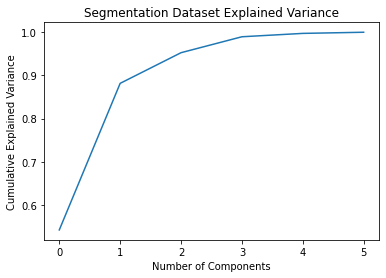

In [16]:
lda = LinearDiscriminantAnalysis()
lda.fit(trainX, trainY)
# Plotting the Cumulative Summation of the Explained Variance
plt.figure()
plt.plot(np.cumsum(lda.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')  # for each component
plt.title('Segmentation Dataset Explained Variance')
plt.show(block=True)

From the histgrams, we can see that the features generated by LDA are roughly obbey the normal distribution.

<Figure size 800x640 with 0 Axes>

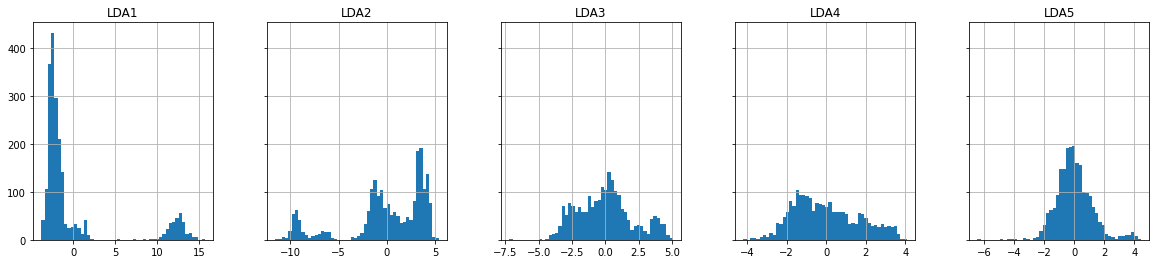

In [17]:
lda = LinearDiscriminantAnalysis(n_components=5)
lda.fit(trainX, trainY)
trainX_lda = lda.transform(trainX)
testX_lda = lda.transform(testX)
# Plot Pairwise relationship between LDA components
plt.figure(figsize=(10, 8), dpi=80)
visualizedf = pd.DataFrame(trainX_lda, columns=['LDA1', 'LDA2', 'LDA3', 'LDA4', 'LDA5'])
visualizedf = pd.concat([visualizedf, pd.DataFrame(ACTUAL_LABELS, columns=['LABELS'])], axis=1)
visualizedf.hist(bins=50, sharey=True, layout=(1, 5), figsize=(20, 4))
# sns.pairplot(visualizedf, vars=visualizedf.columns[:-1], hue="LABELS", palette="husl")
plt.show(block=True)

Then, we trained the Random Forest model with the new dataset. From the report, the performance of the new dataset was as good as the original dataset.

In [18]:
applyrandomforest(trainX_lda, testX_lda, trainY, testY)

Time Elapsed: 1.9859107740000006 secs
Classification Report after applying Random Forest: 
----------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        30
           1       1.00      1.00      1.00        30
           2       0.94      1.00      0.97        30
           3       1.00      1.00      1.00        30
           4       1.00      1.00      1.00        30
           5       1.00      1.00      1.00        30
           6       1.00      0.93      0.97        30

    accuracy                           0.99       210
   macro avg       0.99      0.99      0.99       210
weighted avg       0.99      0.99      0.99       210



## LDA for data compression
From the example of feature extraction above, since the LDA reduce the amount of features, it also compressed the dataset. The more features it reduces, the larger space it saves.

In Image Segmentation Data Set, LDA reduce 73.68% of data size without affecting the classification performance.



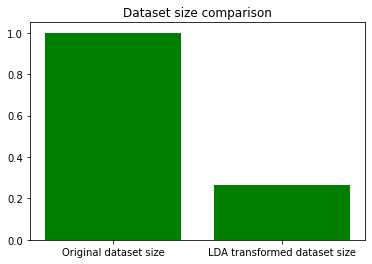

In [19]:
print("In Image Segmentation Data Set, LDA reduce {:2.2%} of data size without affecting the classification performance.\n".format(1 - 5 / 19))
plt.bar(["Original dataset size", "LDA transformed dataset size"], [1, 5 / 19], width=0.8, color="g")
plt.title("Dataset size comparison")
plt.show()

## Other applications
There are some other LDA applications such as bankruptcy prediction, face recognition and biomedical studies. 

## Referrence
[Comparison of LDA and PCA 2D projection of Iris dataset](https://scikit-learn.org/0.16/auto_examples/decomposition/plot_pca_vs_lda.html)  
[Manifold learning on handwritten digits: Locally Linear Embedding, Isomap...](https://scikit-learn.org/0.16/auto_examples/manifold/plot_lle_digits.html#example-manifold-plot-lle-digits-py)  
[Feature Extraction Techniques: PCA, LDA and t-SNE](https://medium.com/analytics-vidhya/feature-extraction-techniques-pca-lda-and-t-sne-df0459c723aa)